Risultato RGB: DBI = 0.9557
Risultato LAB: DBI = 0.7286
Risultato L*: DBI = 0.5189


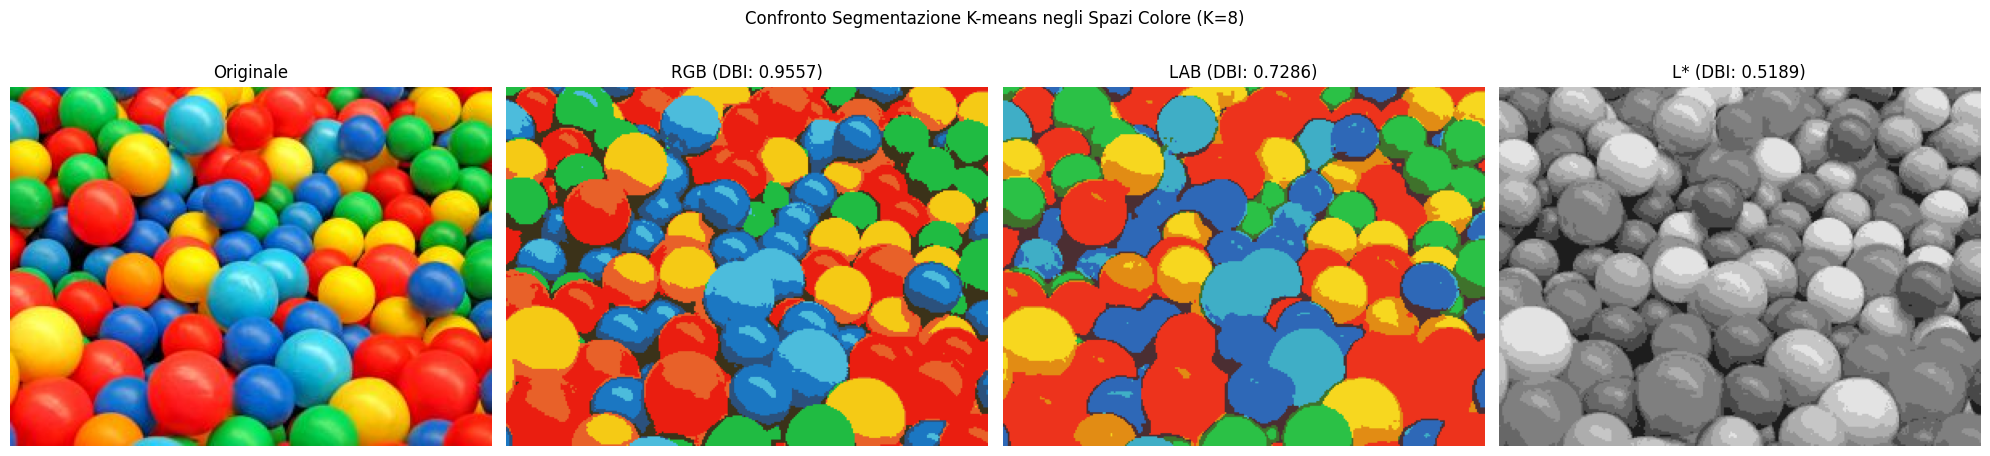

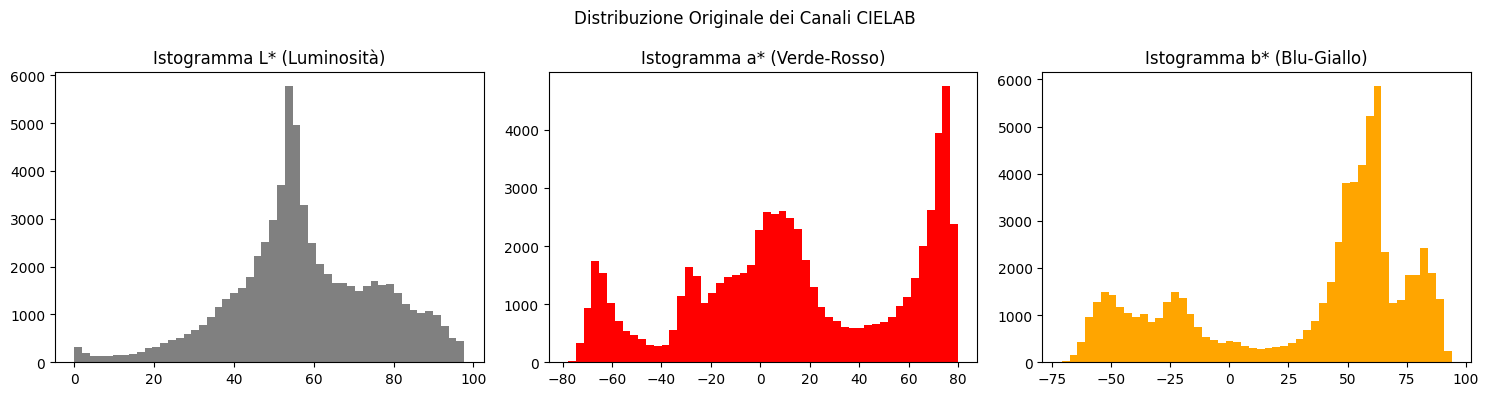

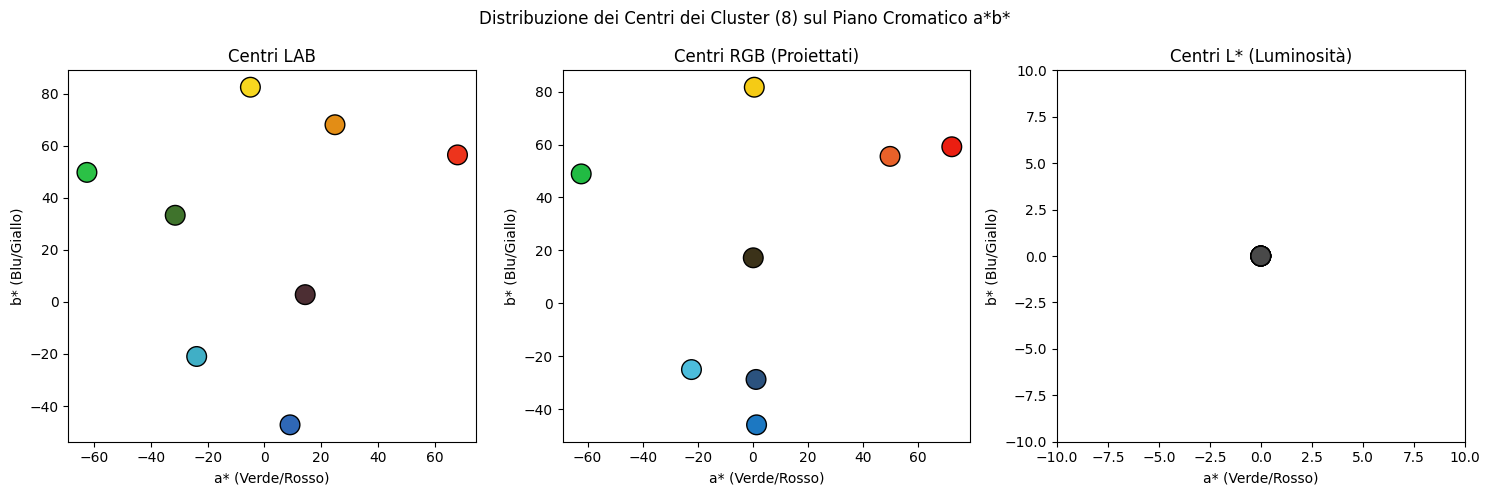

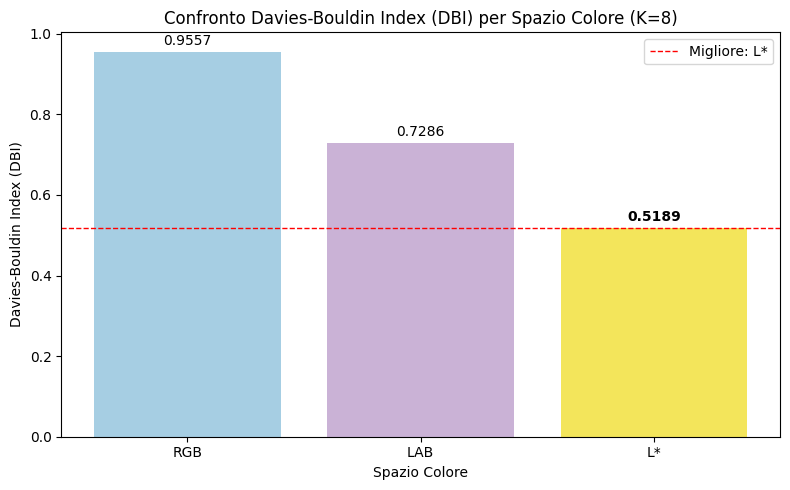

In [8]:
import numpy as np
from skimage import io, color
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- PARAMETRI E CARICAMENTO IMMAGINE ---
K = 8
img = io.imread('./img/balls1.jpg') 
img_norm = img / 255.0

H, W, C = img_norm.shape
pixels_rgb = img_norm.reshape(-1, C)

# Conversione colore CIELAB
pixels_lab = color.rgb2lab(img_norm).reshape(-1, C) 
pixels_l = pixels_lab[:, 0].reshape(-1, 1) # Solo Luminosità L* (Scala di Grigi)

# --- FUNZIONE CLUSTERING E VALUTAZIONE ---
def cluster(data):
    """Esegue K-means e calcola il Davies-Bouldin Index (DBI)."""
    kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(data)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    # DBI: indice di compattezza e separazione (meno è meglio)
    dbi = davies_bouldin_score(data, labels) 
    return labels, centers, dbi

# --- ESECUZIONE CLUSTERING ---
results = {}

for name, data in {
    'RGB': pixels_rgb,
    'LAB': pixels_lab,
    'L*': pixels_l
}.items():
    labels, centers, dbi = cluster(data)
    results[name] = (labels, centers, dbi)
    print(f"Risultato {name}: DBI = {dbi:.4f}")

# --- FUNZIONE RICOSTRUZIONE IMMAGINE ---
def reconstruct(labels, centers, mode):
    """Ricostruisce l'immagine segmentata usando i centri dei cluster."""
    if mode == 'RGB':
        img_rec = centers[labels].reshape(H, W, C)
    elif mode == 'LAB':
        lab = centers[labels].reshape(H, W, C)
        img_rec = color.lab2rgb(lab)
    else:  # L* (Scala di Grigi)
        lab = np.zeros((len(labels), 3))
        lab[:, 0] = centers[labels].flatten()
        img_rec = color.lab2rgb(lab.reshape(H, W, C))
    return (np.clip(img_rec, 0, 1) * 255).astype(np.uint8)

# I. VISUALIZZAZIONE IMMAGINE ORIGINALE + SEGMENTATE
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(img)
axes[0].set_title("Originale")
axes[0].axis('off')

for ax, name in zip(axes[1:], ['RGB', 'LAB', 'L*']):
    labels, centers, dbi = results[name]
    ax.imshow(reconstruct(labels, centers, name))
    ax.set_title(f"{name} (DBI: {dbi:.4f})")
    ax.axis('off')

plt.suptitle(f"Confronto Segmentazione K-means negli Spazi Colore (K={K})")
plt.tight_layout()
plt.show()

# II. ISTOGRAMMI LAB (Per analisi della distribuzione originale)
fig3, axes3 = plt.subplots(1, 3, figsize=(15, 4))
plt.suptitle("Distribuzione Originale dei Canali CIELAB")

axes3[0].hist(pixels_lab[:, 0], bins=50, color='gray')
axes3[0].set_title("Istogramma L* (Luminosità)")

axes3[1].hist(pixels_lab[:, 1], bins=50, color='red')
axes3[1].set_title("Istogramma a* (Verde-Rosso)")

axes3[2].hist(pixels_lab[:, 2], bins=50, color='orange')
axes3[2].set_title("Istogramma b* (Blu-Giallo)")

plt.tight_layout()
plt.show()

# III. ANALISI DEI CENTRI DEI CLUSTER (SPIEGAZIONE DELLE DIFFERENZE)
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f"Distribuzione dei Centri dei Cluster ({K}) sul Piano Cromatico a*b*")

# 1. Centri del Clustering LAB
lab_centers = results['LAB'][1]
axes2[0].scatter(lab_centers[:, 1], lab_centers[:, 2], 
                 c=color.lab2rgb(lab_centers[np.newaxis, :, :])[0], 
                 s=200, edgecolors='black')
axes2[0].set_title(f"Centri LAB")
axes2[0].set_xlabel("a* (Verde/Rosso)")
axes2[0].set_ylabel("b* (Blu/Giallo)")

# 2. Centri del Clustering RGB (convertiti in LAB solo per la visualizzazione)
rgb_centers = results['RGB'][1]
rgb_centers_lab = color.rgb2lab(rgb_centers[np.newaxis, :, :])[0] 
axes2[1].scatter(rgb_centers_lab[:, 1], rgb_centers_lab[:, 2], 
                 c=rgb_centers, s=200, edgecolors='black')
axes2[1].set_title(f"Centri RGB (Proiettati)")
axes2[1].set_xlabel("a* (Verde/Rosso)")
axes2[1].set_ylabel("b* (Blu/Giallo)")

# 3. Centri del Clustering L* (Scala di Grigi)
l_centers = results['L*'][1]
l_centers_lab = np.zeros((K, 3))
l_centers_lab[:, 0] = l_centers.flatten()
l_centers_rgb = color.lab2rgb(l_centers_lab[np.newaxis, :, :])[0]

axes2[2].scatter(l_centers_lab[:, 1], l_centers_lab[:, 2], 
                 c=l_centers_rgb, s=200, edgecolors='black')
axes2[2].set_title(f"Centri L* (Luminosità)")
axes2[2].set_xlabel("a* (Verde/Rosso)")
axes2[2].set_ylabel("b* (Blu/Giallo)")
axes2[2].set_xlim(-10, 10) 
axes2[2].set_ylim(-10, 10)

plt.tight_layout()
plt.show()

# IV. CONFRONTO NUMERICO DELLE PRESTAZIONI (DBI)
dbi_scores = [results[name][2] for name in ['RGB', 'LAB', 'L*']]
names = ['RGB', 'LAB', 'L*']
best_mode = names[np.argmin(dbi_scores)]

fig4, ax4 = plt.subplots(figsize=(8, 5))
bars = ax4.bar(names, dbi_scores, color=['#A6CEE3', '#CAB2D6', '#F3E55B'])
ax4.set_title(f"Confronto Davies-Bouldin Index (DBI) per Spazio Colore (K={K})")
ax4.set_ylabel("Davies-Bouldin Index (DBI)")
ax4.set_xlabel("Spazio Colore")

for bar in bars:
    yval = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), 
             ha='center', va='bottom', fontsize=10, 
             weight='bold' if names[bars.index(bar)] == best_mode else 'normal')

ax4.axhline(y=min(dbi_scores), color='r', linestyle='--', linewidth=1, 
            label=f'Migliore: {best_mode}')
ax4.legend()
plt.tight_layout()
plt.show()

